#**SETUP LINGKUNGAN**

In [2]:
!pip install timm torchinfo scikit-learn tqdm

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import timm
from sklearn.metrics import classification_report, confusion_matrix
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {device}")

Menggunakan perangkat: cuda


#**PRE PROCESSING**

In [5]:
IMAGE_SIZE = 224
NORM_MEAN = (0.485, 0.456, 0.406)
NORM_STD = (0.229, 0.224, 0.225)
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

full_train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True, #
    transform=train_transforms
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=val_transforms
)

NUM_CLASSES = len(full_train_dataset.classes)

TRAIN_RATIO = 0.8
train_size = int(TRAIN_RATIO * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset_raw = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset_raw, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nDataset CIFAR-10 berhasil dimuat dan dibagi:")
print(f"  Jumlah Kelas: {NUM_CLASSES} (Memenuhi syarat minimal 3 kelas tugas)")
print(f"  Data Training (80%): {len(train_dataset)} sampel")
print(f"  Data Validation (20%): {len(val_dataset_raw)} sampel")
print(f"  Data Test Set CIFAR-10: {len(test_dataset)} sampel")

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]



Dataset CIFAR-10 berhasil dimuat dan dibagi:
  Jumlah Kelas: 10 (Memenuhi syarat minimal 3 kelas tugas)
  Data Training (80%): 40000 sampel
  Data Validation (20%): 10000 sampel
  Data Test Set CIFAR-10: 10000 sampel


#**MODEL VIT, DEIT, DAN SWIN**

In [ ]:
VIT_MODEL = 'vit_base_patch16_224'
DEIT_MODEL = 'deit_base_patch16_224'
SWIN_MODEL = 'swin_base_patch4_window7_224'
MODEL_NAMES = [VIT_MODEL, DEIT_MODEL, SWIN_MODEL]
LOADED_MODELS = {}
PARAM_METRICS = []

def get_model_and_metrics(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    model.to(device)
    model_summary = summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), verbose=0)

    metrics = {
        'Model': model_name,
        'Total Parameter': model_summary.total_params,
        'Trainable Parameter': model_summary.trainable_params,
        'Non-Trainable Parameter': model_summary.total_params - model_summary.trainable_params,
        'Ukuran Model (MB)': model_summary.total_param_bytes / (1024 * 1024)
    }

    print(f"\n--- Ringkasan Parameter: {model_name} ---")
    for key, value in metrics.items():
        if key == 'Model':
            print(f"{key}: {value}")
        elif 'Parameter' in key:
            print(f"{key}: {value:,}")
        else:
            print(f"{key}: {value:.2f} MB")

    return model, metrics

for name in MODEL_NAMES:
    model, metrics = get_model_and_metrics(name, NUM_CLASSES)
    LOADED_MODELS[name] = model
    PARAM_METRICS.append(metrics)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


--- Ringkasan Parameter: vit_base_patch16_224 ---
Model: vit_base_patch16_224
Total Parameter: 85,806,346
Trainable Parameter: 85,806,346
Non-Trainable Parameter: 0
Ukuran Model (MB): 326.75 MB


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


--- Ringkasan Parameter: deit_base_patch16_224 ---
Model: deit_base_patch16_224
Total Parameter: 85,806,346
Trainable Parameter: 85,806,346
Non-Trainable Parameter: 0
Ukuran Model (MB): 326.75 MB


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]


--- Ringkasan Parameter: swin_base_patch4_window7_224 ---
Model: swin_base_patch4_window7_224
Total Parameter: 86,753,474
Trainable Parameter: 86,753,474
Non-Trainable Parameter: 0
Ukuran Model (MB): 330.70 MB


#**TRAINING ViT**


Memulai Training Model: vit_base_patch16_224...


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 0.1216 (Acc: 96.43%) | Val Loss: 0.0568 (Acc: 98.24%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.0235 (Acc: 99.22%) | Val Loss: 0.0688 (Acc: 98.05%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.0169 (Acc: 99.46%) | Val Loss: 0.0602 (Acc: 98.39%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.0146 (Acc: 99.58%) | Val Loss: 0.0665 (Acc: 98.26%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.0105 (Acc: 99.67%) | Val Loss: 0.0551 (Acc: 98.56%)

 Training vit_base_patch16_224 SELESAI. Model disimpan.


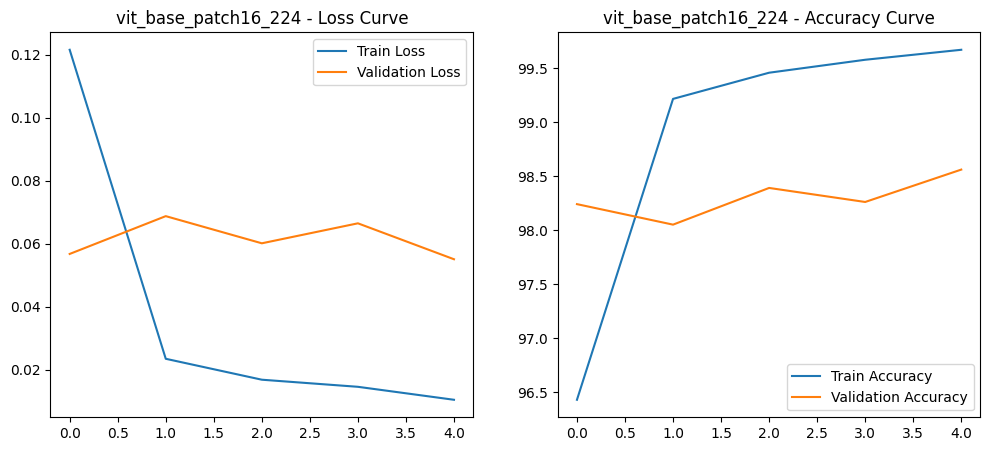

In [ ]:
LEARNING_RATE = 1e-5
NUM_EPOCHS = 5
OPTIMIZER = optim.AdamW
CRITERION = nn.CrossEntropyLoss()

model_to_train_name = VIT_MODEL
model_to_train = LOADED_MODELS[model_to_train_name]
optimizer = OPTIMIZER(model_to_train.parameters(), lr=LEARNING_RATE)

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    dataloader_progress = tqdm(dataloader, desc="Training")

    for inputs, labels in dataloader_progress:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        current_loss = total_loss / total
        current_acc = 100 * correct / total
        dataloader_progress.set_postfix(loss=f'{current_loss:.4f}', acc=f'{current_acc:.2f}%')

    return total_loss / total, 100 * correct / total

def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        dataloader_progress = tqdm(dataloader, desc="Validation")

        for inputs, labels in dataloader_progress: # Gunakan dataloader yang sudah dibungkus
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            current_loss = total_loss / total
            current_acc = 100 * correct / total
            dataloader_progress.set_postfix(loss=f'{current_loss:.4f}', acc=f'{current_acc:.2f}%')

    return total_loss / total, 100 * correct / total

# --- LOOP PELATIHAN ---
print(f"\nMemulai Training Model: {model_to_train_name}...")

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model_to_train, train_loader, CRITERION, optimizer)
    val_loss, val_acc = validate_one_epoch(model_to_train, val_loader, CRITERION)

    # Simpan hasil untuk kurva pembelajaran
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} (Acc: {train_acc:.2f}%) | Val Loss: {val_loss:.4f} (Acc: {val_acc:.2f}%)")

# Simpan model yang sudah dilatih
LOADED_MODELS[model_to_train_name] = model_to_train
print(f"\n Training {model_to_train_name} SELESAI. Model disimpan.")

# VISUALISASI KURVA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f'{model_to_train_name} - Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title(f'{model_to_train_name} - Accuracy Curve')
plt.legend()
plt.show()

In [ ]:
model_to_save_name = VIT_MODEL
model_save_path = f"{model_to_save_name}_final_weights.pth"
torch.save(model_to_train.state_dict(), model_save_path)
print(f"Model {model_to_save_name} berhasil disimpan ke: {model_save_path}")

Model vit_base_patch16_224 berhasil disimpan ke: vit_base_patch16_224_final_weights.pth


#**METRIK PERFORMA ViT**

Memulai Warm-up...
Warm-up Selesai. Memulai pengukuran inferensi...

File hasil prediksi tersimpan di: predictions_vit_base_patch16_224.csv

--- Hasil Inferensi vit_base_patch16_224 ---
Hardware Digunakan: cuda
Total Sampel Inferensi: 10000
Waktu Rata-rata per Gambar: 9.843 ms
Throughput: 101.60 gambar/detik

--- Classification Report (Performance Metrics) ---
              precision    recall  f1-score   support

    airplane       0.99      0.99      0.99       973
  automobile       1.00      0.99      0.99      1010
        bird       0.98      0.99      0.99      1006
         cat       0.95      0.98      0.97       967
        deer       0.99      0.99      0.99       963
         dog       0.99      0.96      0.97      1024
        frog       0.99      0.99      0.99      1025
       horse       1.00      0.99      0.99      1035
        ship       0.99      0.99      0.99       998
       truck       0.99      1.00      0.99       999

    accuracy                           0.

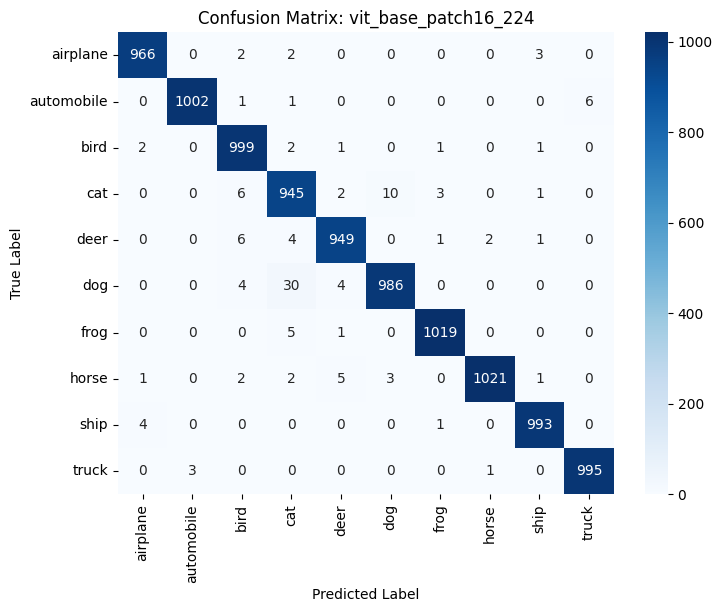

In [ ]:
model_to_eval_name = VIT_MODEL
model_to_eval = LOADED_MODELS[model_to_eval_name]

def evaluate_and_time(model, dataloader, dataset, model_name, output_filename="predictions_output.csv"):
    model.eval()

    all_preds = []
    all_labels = []
    inference_times_ms = []

    print("Memulai Warm-up...")
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if i < 5:
                inputs = inputs.to(device)
                _ = model(inputs)
            else:
                break
    print("Warm-up Selesai. Memulai pengukuran inferensi...")

    # Pengukuran Inferensi
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            total_samples += labels.size(0)

            # Waktu Inferensi per batch
            if device.type == 'cuda':
                starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
                starter.record()
                outputs = model(inputs)
                ender.record()
                torch.cuda.synchronize()
                curr_time = starter.elapsed_time(ender)
            else:
                t0 = time.time()
                outputs = model(inputs)
                t1 = time.time()
                curr_time = (t1 - t0) * 1000

            inference_times_ms.append(curr_time)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Menyimpan File Hasil Prediksi ---
    results_df = pd.DataFrame({
        'True_Label_ID': all_labels,
        'Predicted_Label_ID': all_preds,
        'True_Label_Name': [dataset.classes[l] for l in all_labels],
        'Predicted_Label_Name': [dataset.classes[p] for p in all_preds]
    })

    # Simpan DataFrame ke file CSV
    results_df.to_csv(output_filename, index=False)
    print(f"\nFile hasil prediksi tersimpan di: {output_filename}")


    # --- Perhitungan Metrik Inferensi ---
    total_time_ms = sum(inference_times_ms)
    avg_time_per_image_ms = total_time_ms / total_samples
    throughput_ips = total_samples / (total_time_ms / 1000)

    print(f"\n--- Hasil Inferensi {model_name} ---")
    print(f"Hardware Digunakan: {device}")
    print(f"Total Sampel Inferensi: {total_samples}")
    print(f"Waktu Rata-rata per Gambar: {avg_time_per_image_ms:.3f} ms")
    print(f"Throughput: {throughput_ips:.2f} gambar/detik")

    # --- Perhitungan Metrik Performa ---
    print("\n--- Classification Report (Performance Metrics) ---")
    report = classification_report(all_labels, all_preds, target_names=dataset.classes, output_dict=False)
    print(report)

    # Confusion Matrix (untuk visualisasi)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Jalankan evaluasi untuk model yang dipilih
output_file = f"predictions_{model_to_eval_name}.csv"
evaluate_and_time(model_to_eval, val_loader, full_train_dataset, model_to_eval_name, output_file)

#**TRAINING DeiT**



Memulai Training Model: deit_base_patch16_224...


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 0.2515 (Acc: 93.52%) | Val Loss: 0.0766 (Acc: 97.49%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.0364 (Acc: 98.92%) | Val Loss: 0.0583 (Acc: 98.22%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.0145 (Acc: 99.62%) | Val Loss: 0.0741 (Acc: 97.92%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.0105 (Acc: 99.71%) | Val Loss: 0.0654 (Acc: 98.09%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.0067 (Acc: 99.80%) | Val Loss: 0.0638 (Acc: 98.24%)

 Training deit_base_patch16_224 SELESAI. Model disimpan.


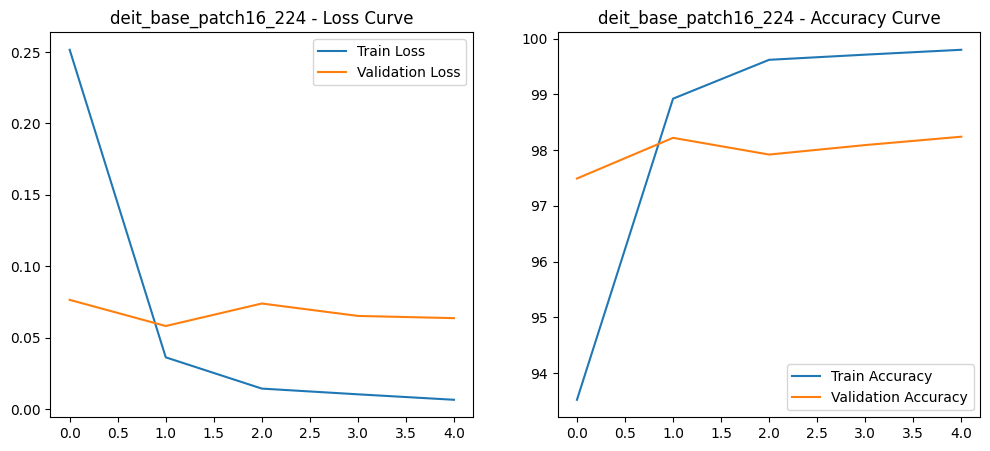

In [ ]:
LEARNING_RATE = 1e-5
NUM_EPOCHS = 5
OPTIMIZER = optim.AdamW
CRITERION = nn.CrossEntropyLoss()

model_to_train_name = DEIT_MODEL
model_to_train = LOADED_MODELS[model_to_train_name]
optimizer = OPTIMIZER(model_to_train.parameters(), lr=LEARNING_RATE)

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    dataloader_progress = tqdm(dataloader, desc="Training")

    for inputs, labels in dataloader_progress:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        current_loss = total_loss / total
        current_acc = 100 * correct / total
        dataloader_progress.set_postfix(loss=f'{current_loss:.4f}', acc=f'{current_acc:.2f}%')

    return total_loss / total, 100 * correct / total

def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        dataloader_progress = tqdm(dataloader, desc="Validation")

        for inputs, labels in dataloader_progress: # Gunakan dataloader yang sudah dibungkus
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            current_loss = total_loss / total
            current_acc = 100 * correct / total
            dataloader_progress.set_postfix(loss=f'{current_loss:.4f}', acc=f'{current_acc:.2f}%')

    return total_loss / total, 100 * correct / total

# --- LOOP PELATIHAN ---
print(f"\nMemulai Training Model: {model_to_train_name}...")

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model_to_train, train_loader, CRITERION, optimizer)
    val_loss, val_acc = validate_one_epoch(model_to_train, val_loader, CRITERION)

    # Simpan hasil untuk kurva pembelajaran
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} (Acc: {train_acc:.2f}%) | Val Loss: {val_loss:.4f} (Acc: {val_acc:.2f}%)")

# Simpan model yang sudah dilatih
LOADED_MODELS[model_to_train_name] = model_to_train
print(f"\n Training {model_to_train_name} SELESAI. Model disimpan.")

# VISUALISASI KURVA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f'{model_to_train_name} - Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title(f'{model_to_train_name} - Accuracy Curve')
plt.legend()
plt.show()

In [ ]:
model_to_save_name = DEIT_MODEL
model_save_path = f"{model_to_save_name}_final_weights.pth"
torch.save(model_to_train.state_dict(), model_save_path)
print(f"Model {model_to_save_name} berhasil disimpan ke: {model_save_path}")

Model deit_base_patch16_224 berhasil disimpan ke: deit_base_patch16_224_final_weights.pth


#**METRIK PERFORMA DeiT**

Memulai Warm-up...
Warm-up Selesai. Memulai pengukuran inferensi...

File hasil prediksi tersimpan di: predictions_deit_base_patch16_224.csv

--- Hasil Inferensi deit_base_patch16_224 ---
Hardware Digunakan: cuda
Total Sampel Inferensi: 10000
Waktu Rata-rata per Gambar: 10.113 ms
Throughput: 98.88 gambar/detik

--- Classification Report (Performance Metrics) ---
              precision    recall  f1-score   support

    airplane       0.98      0.98      0.98       973
  automobile       0.99      0.99      0.99      1010
        bird       0.98      0.99      0.98      1006
         cat       0.97      0.95      0.96       967
        deer       0.98      0.98      0.98       963
         dog       0.97      0.98      0.97      1024
        frog       0.99      0.99      0.99      1025
       horse       0.98      0.98      0.98      1035
        ship       0.99      0.99      0.99       998
       truck       0.99      0.99      0.99       999

    accuracy                           

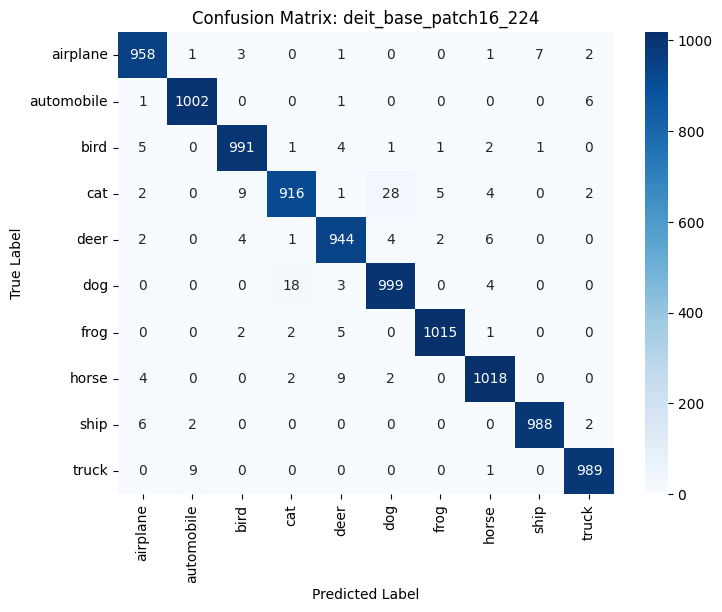

In [ ]:
model_to_eval_name = DEIT_MODEL
model_to_eval = LOADED_MODELS[model_to_eval_name]

def evaluate_and_time(model, dataloader, dataset, model_name, output_filename="predictions_output.csv"):
    model.eval()

    all_preds = []
    all_labels = []
    inference_times_ms = []

    print("Memulai Warm-up...")
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if i < 5:
                inputs = inputs.to(device)
                _ = model(inputs)
            else:
                break
    print("Warm-up Selesai. Memulai pengukuran inferensi...")

    # Pengukuran Inferensi
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            total_samples += labels.size(0)

            # Waktu Inferensi per batch
            if device.type == 'cuda':
                starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
                starter.record()
                outputs = model(inputs)
                ender.record()
                torch.cuda.synchronize()
                curr_time = starter.elapsed_time(ender)
            else:
                t0 = time.time()
                outputs = model(inputs)
                t1 = time.time()
                curr_time = (t1 - t0) * 1000

            inference_times_ms.append(curr_time)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Menyimpan File Hasil Prediksi ---
    results_df = pd.DataFrame({
        'True_Label_ID': all_labels,
        'Predicted_Label_ID': all_preds,
        'True_Label_Name': [dataset.classes[l] for l in all_labels],
        'Predicted_Label_Name': [dataset.classes[p] for p in all_preds]
    })

    # Simpan DataFrame ke file CSV
    results_df.to_csv(output_filename, index=False)
    print(f"\nFile hasil prediksi tersimpan di: {output_filename}")


    # --- Perhitungan Metrik Inferensi ---
    total_time_ms = sum(inference_times_ms)
    avg_time_per_image_ms = total_time_ms / total_samples
    throughput_ips = total_samples / (total_time_ms / 1000)

    print(f"\n--- Hasil Inferensi {model_name} ---")
    print(f"Hardware Digunakan: {device}")
    print(f"Total Sampel Inferensi: {total_samples}")
    print(f"Waktu Rata-rata per Gambar: {avg_time_per_image_ms:.3f} ms")
    print(f"Throughput: {throughput_ips:.2f} gambar/detik")

    # --- Perhitungan Metrik Performa ---
    print("\n--- Classification Report (Performance Metrics) ---")
    report = classification_report(all_labels, all_preds, target_names=dataset.classes, output_dict=False)
    print(report)

    # Confusion Matrix (untuk visualisasi)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Jalankan evaluasi untuk model yang dipilih
output_file = f"predictions_{model_to_eval_name}.csv"
evaluate_and_time(model_to_eval, val_loader, full_train_dataset, model_to_eval_name, output_file)

#**TRAINING Swin**


Memulai Training Model: swin_base_patch4_window7_224...


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 0.1835 (Acc: 94.88%) | Val Loss: 0.0443 (Acc: 98.49%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.0327 (Acc: 98.97%) | Val Loss: 0.0448 (Acc: 98.63%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.0190 (Acc: 99.39%) | Val Loss: 0.0394 (Acc: 98.89%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.0136 (Acc: 99.59%) | Val Loss: 0.0398 (Acc: 98.85%)


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.0115 (Acc: 99.67%) | Val Loss: 0.0603 (Acc: 98.53%)

 Training swin_base_patch4_window7_224 SELESAI. Model disimpan.


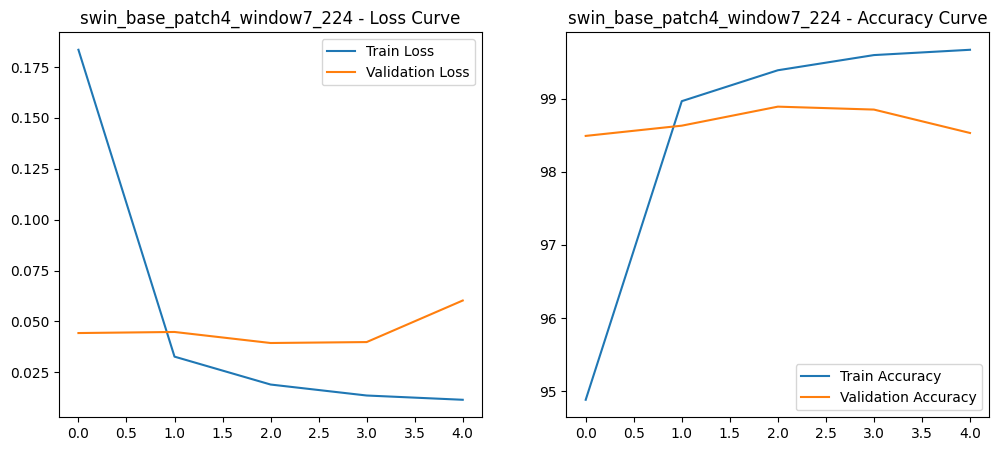

In [ ]:
LEARNING_RATE = 1e-5
NUM_EPOCHS = 5
OPTIMIZER = optim.AdamW
CRITERION = nn.CrossEntropyLoss()

model_to_train_name = SWIN_MODEL
model_to_train = LOADED_MODELS[model_to_train_name]
optimizer = OPTIMIZER(model_to_train.parameters(), lr=LEARNING_RATE)

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    dataloader_progress = tqdm(dataloader, desc="Training")

    for inputs, labels in dataloader_progress:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        current_loss = total_loss / total
        current_acc = 100 * correct / total
        dataloader_progress.set_postfix(loss=f'{current_loss:.4f}', acc=f'{current_acc:.2f}%')

    return total_loss / total, 100 * correct / total

def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        dataloader_progress = tqdm(dataloader, desc="Validation")

        for inputs, labels in dataloader_progress: # Gunakan dataloader yang sudah dibungkus
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            current_loss = total_loss / total
            current_acc = 100 * correct / total
            dataloader_progress.set_postfix(loss=f'{current_loss:.4f}', acc=f'{current_acc:.2f}%')

    return total_loss / total, 100 * correct / total

# --- LOOP PELATIHAN ---
print(f"\nMemulai Training Model: {model_to_train_name}...")

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model_to_train, train_loader, CRITERION, optimizer)
    val_loss, val_acc = validate_one_epoch(model_to_train, val_loader, CRITERION)

    # Simpan hasil untuk kurva pembelajaran
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} (Acc: {train_acc:.2f}%) | Val Loss: {val_loss:.4f} (Acc: {val_acc:.2f}%)")

# Simpan model yang sudah dilatih
LOADED_MODELS[model_to_train_name] = model_to_train
print(f"\n Training {model_to_train_name} SELESAI. Model disimpan.")

# VISUALISASI KURVA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f'{model_to_train_name} - Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title(f'{model_to_train_name} - Accuracy Curve')
plt.legend()
plt.show()

In [ ]:
model_to_save_name = SWIN_MODEL
model_save_path = f"{model_to_save_name}_final_weights.pth"
torch.save(model_to_train.state_dict(), model_save_path)
print(f"Model {model_to_save_name} berhasil disimpan ke: {model_save_path}")

Model swin_base_patch4_window7_224 berhasil disimpan ke: swin_base_patch4_window7_224_final_weights.pth


#**METRIK PERFORMA Swin**

Memulai Warm-up...
Warm-up Selesai. Memulai pengukuran inferensi...

File hasil prediksi tersimpan di: predictions_swin_base_patch4_window7_224.csv

--- Hasil Inferensi swin_base_patch4_window7_224 ---
Hardware Digunakan: cuda
Total Sampel Inferensi: 10000
Waktu Rata-rata per Gambar: 11.106 ms
Throughput: 90.04 gambar/detik

--- Classification Report (Performance Metrics) ---
              precision    recall  f1-score   support

    airplane       1.00      0.99      0.99       973
  automobile       1.00      0.97      0.98      1010
        bird       0.99      0.99      0.99      1006
         cat       0.97      0.97      0.97       967
        deer       0.98      0.98      0.98       963
         dog       0.97      0.99      0.98      1024
        frog       1.00      1.00      1.00      1025
       horse       1.00      0.98      0.99      1035
        ship       1.00      0.99      1.00       998
       truck       0.97      1.00      0.98       999

    accuracy             

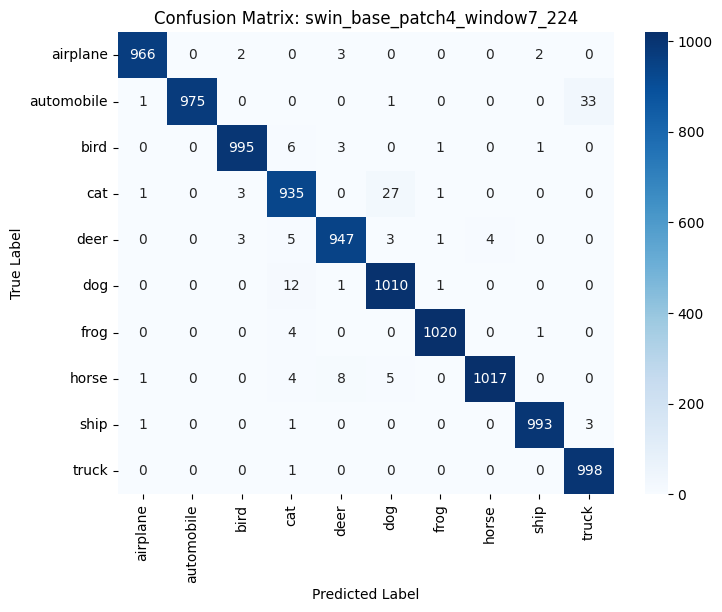

In [ ]:
model_to_eval_name = SWIN_MODEL
model_to_eval = LOADED_MODELS[model_to_eval_name]

def evaluate_and_time(model, dataloader, dataset, model_name, output_filename="predictions_output.csv"):
    model.eval()

    all_preds = []
    all_labels = []
    inference_times_ms = []

    print("Memulai Warm-up...")
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if i < 5:
                inputs = inputs.to(device)
                _ = model(inputs)
            else:
                break
    print("Warm-up Selesai. Memulai pengukuran inferensi...")

    # Pengukuran Inferensi
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            total_samples += labels.size(0)

            # Waktu Inferensi per batch
            if device.type == 'cuda':
                starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
                starter.record()
                outputs = model(inputs)
                ender.record()
                torch.cuda.synchronize()
                curr_time = starter.elapsed_time(ender)
            else:
                t0 = time.time()
                outputs = model(inputs)
                t1 = time.time()
                curr_time = (t1 - t0) * 1000

            inference_times_ms.append(curr_time)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Menyimpan File Hasil Prediksi ---
    results_df = pd.DataFrame({
        'True_Label_ID': all_labels,
        'Predicted_Label_ID': all_preds,
        'True_Label_Name': [dataset.classes[l] for l in all_labels],
        'Predicted_Label_Name': [dataset.classes[p] for p in all_preds]
    })

    # Simpan DataFrame ke file CSV
    results_df.to_csv(output_filename, index=False)
    print(f"\nFile hasil prediksi tersimpan di: {output_filename}")


    # --- Perhitungan Metrik Inferensi ---
    total_time_ms = sum(inference_times_ms)
    avg_time_per_image_ms = total_time_ms / total_samples
    throughput_ips = total_samples / (total_time_ms / 1000)

    print(f"\n--- Hasil Inferensi {model_name} ---")
    print(f"Hardware Digunakan: {device}")
    print(f"Total Sampel Inferensi: {total_samples}")
    print(f"Waktu Rata-rata per Gambar: {avg_time_per_image_ms:.3f} ms")
    print(f"Throughput: {throughput_ips:.2f} gambar/detik")

    # --- Perhitungan Metrik Performa ---
    print("\n--- Classification Report (Performance Metrics) ---")
    report = classification_report(all_labels, all_preds, target_names=dataset.classes, output_dict=False)
    print(report)

    # Confusion Matrix (untuk visualisasi)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Jalankan evaluasi untuk model yang dipilih
output_file = f"predictions_{model_to_eval_name}.csv"
evaluate_and_time(model_to_eval, val_loader, full_train_dataset, model_to_eval_name, output_file)